In [1]:
import sys
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sys.path.insert(0,'../')


In [2]:
def load_bull_and_bear(bull_data, bear_data, folder_path='../db/result/strategies/'):
    # 列出文件夹下的所有文件
    files = os.listdir(folder_path)

    for file in tqdm(files, desc='Loading files'):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            # 检查文件名中是否包含 "Bear" 或 "Bull"
            if 'Bear' in file:
                df = pd.read_excel(file_path)
                bear_data.append(df)
            elif 'Bull' in file:
                df = pd.read_excel(file_path)
                bull_data.append(df)
                
    return bull_data, bear_data 


def load():
    # 读取并分组数据
    bear_data, bull_data = [],[]

    if not bull_data or not bear_data:
        bull_data, bear_data = load_bull_and_bear(bull_data, bear_data)
        
    return bull_data, bear_data 

bull_data, bear_data = load()

Loading files:   0%|          | 0/91839 [00:00<?, ?it/s]

Loading files: 100%|██████████| 91839/91839 [25:42<00:00, 59.54it/s]  


In [3]:
def group_by_contract_code(data):
    groups = []
    for df in tqdm(data, desc='Grouping by contract code'):
        if not df.empty:
            df = df.dropna()
            groups.append(df)
    return groups


In [4]:
# 根据contract_code的第一个部分进行分组
bear_groups = group_by_contract_code(bear_data)
bull_groups = group_by_contract_code(bull_data)

# 删除bull_data和bear_data
del bull_data
del bear_data

Grouping by contract code:   0%|          | 0/38997 [00:00<?, ?it/s]

Grouping by contract code: 100%|██████████| 52842/52842 [00:24<00:00, 2156.10it/s]


In [5]:
def calculate_results(groups):
        results = pd.DataFrame()
        mean = []
        total_groups = len(groups)
        for group in tqdm(groups, total=total_groups, desc='Calculating results'):
            try:      
                portfolio_mean = group[[ 'exact_return', 'volatility', 'DELTA', 'THETA', 'GAMMA', 'VEGA', 'RHO']].mean()
                code = group[['contract_code']]
                portfolio_mean['contract_code'] = code.iloc[0, 0] 
                mean.append(portfolio_mean)
            except:
                continue

        results = pd.concat(mean, axis=1).T.set_index('contract_code')
        return results


bear_result = calculate_results(bear_groups)
bull_result = calculate_results(bull_groups)



Calculating results: 100%|██████████| 52842/52842 [00:51<00:00, 1025.77it/s]


In [6]:
def group_by_type_results(groups):
    put_group = []
    call_group = []
    total_groups = len(groups)
    for group in tqdm(groups, total=total_groups, desc='Calculating results'):
        try:    
            code = group[['contract_code']].iloc[0, 0]      
            if "-P-" in code: 
                    call_group.append(group)
            elif "-C-" in code: 
                    put_group.append(group)
            else:
                pass
        except:
            continue
    return call_group, put_group

bear_put_groups, bear_call_groups = group_by_type_results(bear_groups)
bull_put_groups, bull_call_groups = group_by_type_results(bull_groups)

bear_put_groups = calculate_results(bear_put_groups)
bear_call_groups = calculate_results(bear_call_groups)
bull_put_groups = calculate_results(bull_put_groups)
bull_call_groups = calculate_results(bull_call_groups)

Calculating results:   0%|          | 0/38997 [00:00<?, ?it/s]

Calculating results: 100%|██████████| 27811/27811 [00:23<00:00, 1201.16it/s]


In [7]:
def max_drawdown(prices):
    max_dd = 0
    peak = prices[0]

    for price in prices:
        if price > peak:
            peak = price
        dd = (peak - price) / peak
        if dd > max_dd:
            max_dd = dd

    return max_dd

def compare_strategy_performance(groups):
    results = pd.DataFrame()
    # 计算每种策略的夏普比率、盈利能力和回撤等指标
    sharpes = []
    drawdowns = []
    mean = []
    total_groups = len(groups)
    
    for group in tqdm(groups, total=total_groups, desc='Calculating results'):
        exact_return = group['exact_return']
        volatility = group['volatility']
        if volatility != 0:  # 避免除以零错误
            sharpe = exact_return / volatility
        else:
            sharpe = 0
        sharpes.append(sharpe)
        drawdowns = max_drawdown(exact_return)
        group['sharpes'] = sharpes
        group['drawdowns'] = drawdowns
        
        portfolio_mean = group[[ 'exact_return', 'sharpes', 'drawdowns','volatility', 'DELTA', 'THETA', 'GAMMA', 'VEGA', 'RHO']].mean()
        code = group[['contract_code']]
        portfolio_mean['contract_code'] = code.iloc[0, 0] 
        mean.append(portfolio_mean)

    results = pd.concat(mean, axis=1).T.set_index('contract_code')
    return results

# compare_strategy_performance(bull_result)


In [12]:
def plot_frequency(column, result):
    # 计算值的范围
    min_val = result[column].min()
    max_val = result[column].max()
    
    # 创建 500 个均匀间隔的区间
    bins = np.linspace(min_val, max_val, 500)
    
    # 使用 seaborn 绘制直方图并叠加 KDE 曲线
    plt.figure(figsize=(8, 6))
    sns.histplot(result[column], bins=bins, kde=True)
    
    # 计算众数、中位数和平均数
    median_val = result[column].median()
    mean_val = result[column].mean()
    
    # 在图中标出众数、中位数和平均数
    plt.axvline(x=median_val, color='r', linestyle='--', label=f'Median: {median_val}')
    plt.axvline(x=mean_val, color='orange', linestyle='--', label=f'Mean: {mean_val}')
    plt.legend()
    
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


def distribution_characteristics(column, data):
    data= data[column]
    skewness = data.skew()
    kurtosis = data.kurtosis()
    tail_thickness = "fat" if kurtosis > 3 else "thin"
    peak = "peaked" if kurtosis > 3 else "flat"
    skew = "right-skewed" if skewness > 0 else "left-skewed" if skewness < 0 else "symmetric"
    
    character = {
        "Tail Thickness": tail_thickness,
        "Peak Shape": peak,
        "Skew": skew
    }
    
    print(character)


def static_summary(result):
    columns = ['exact_return', 'DELTA', 'THETA', 'GAMMA', 'VEGA']
    for column in columns:
        plot_frequency(column, result)
        distribution_characteristics(column, result)



## 总体 bull spread、 bear spread 策略结果

bull_result:



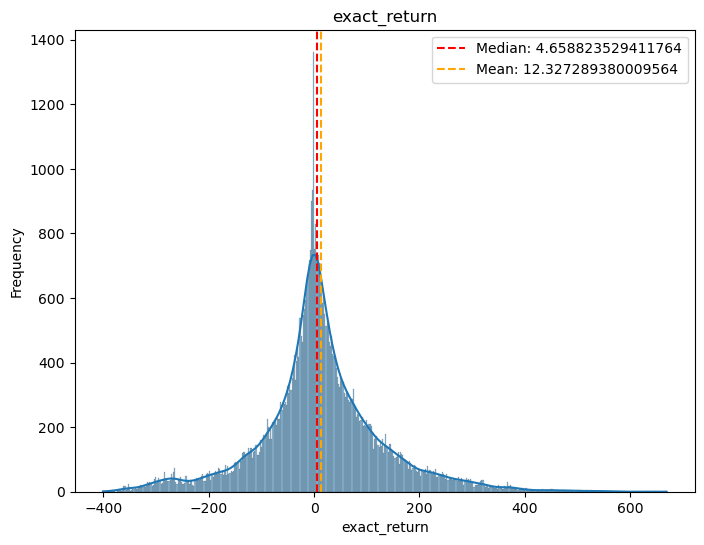

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


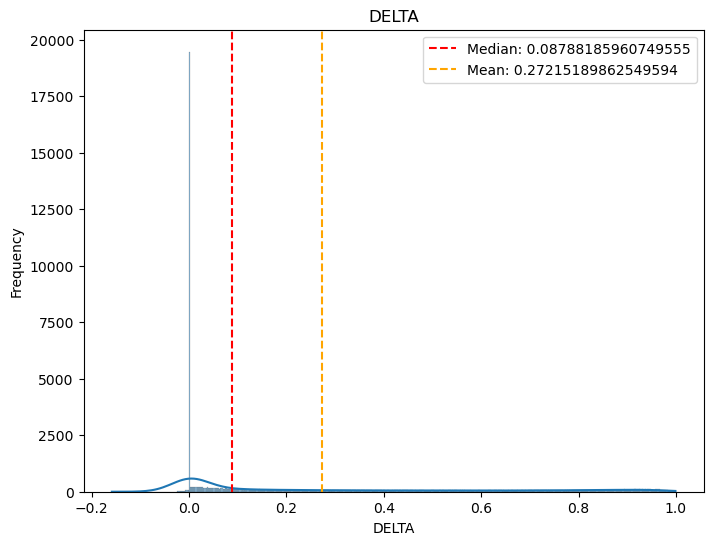

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


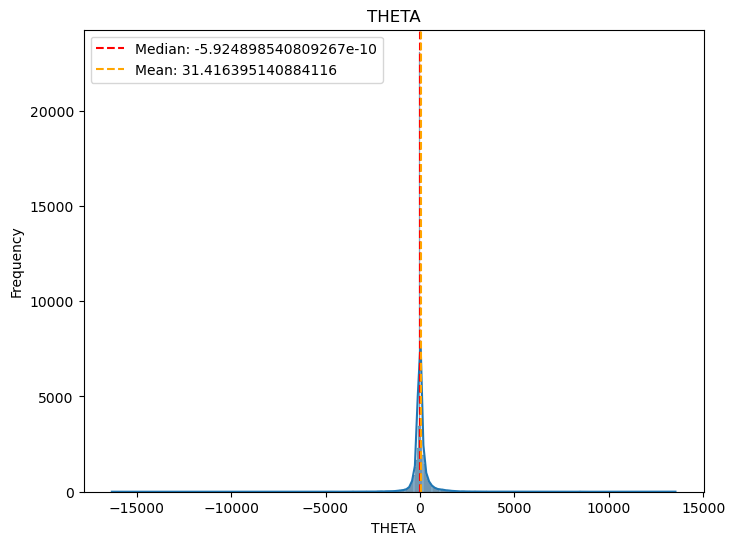

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'left-skewed'}


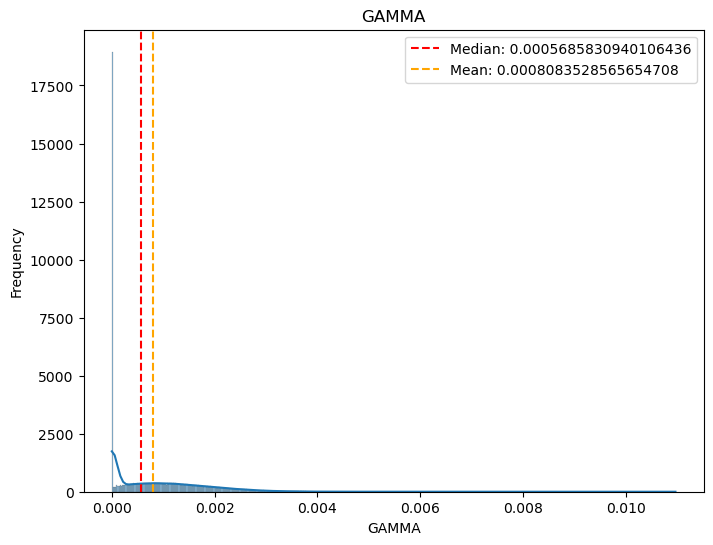

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


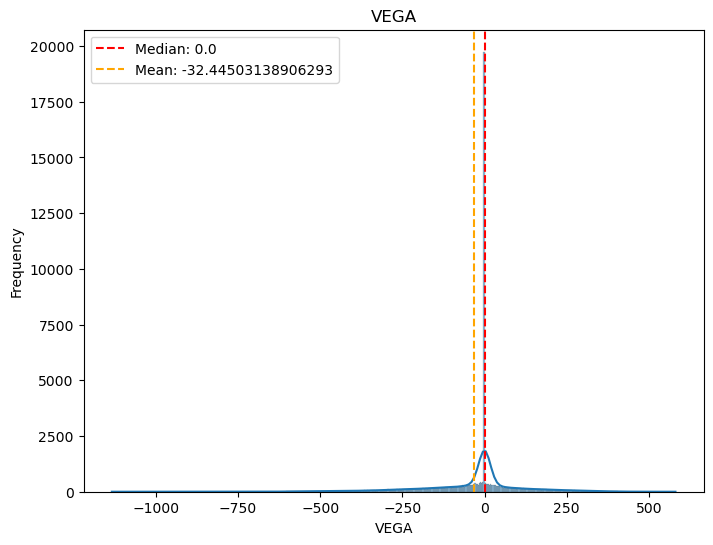

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'left-skewed'}




bear_result:



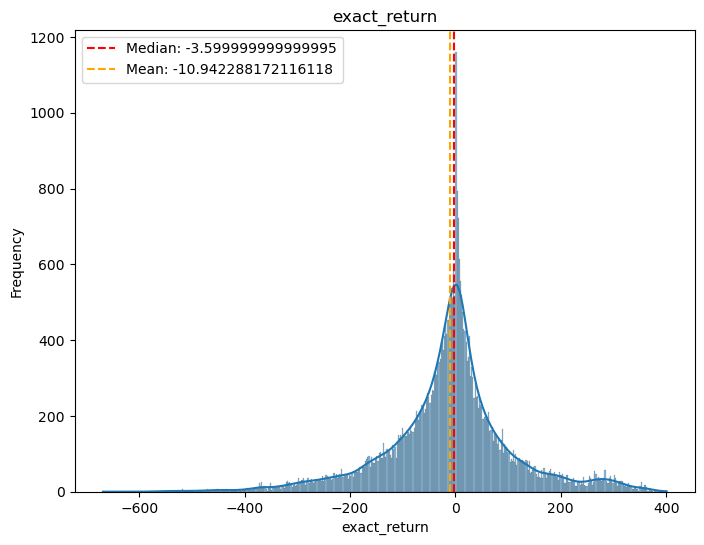

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'left-skewed'}


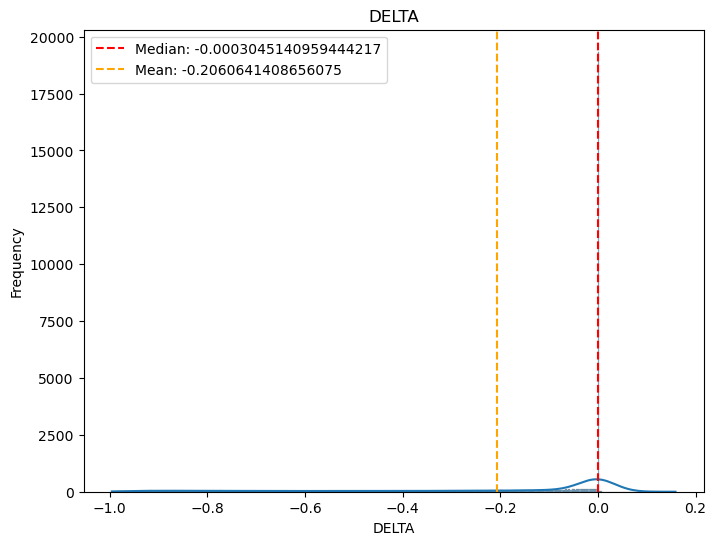

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'left-skewed'}


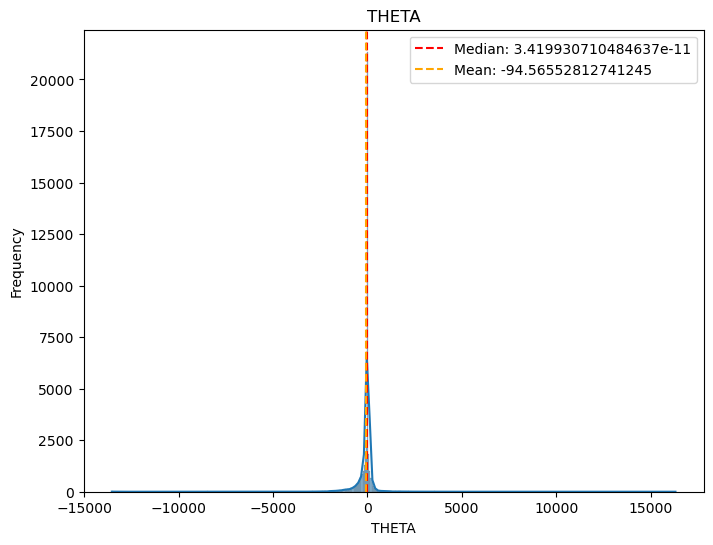

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'right-skewed'}


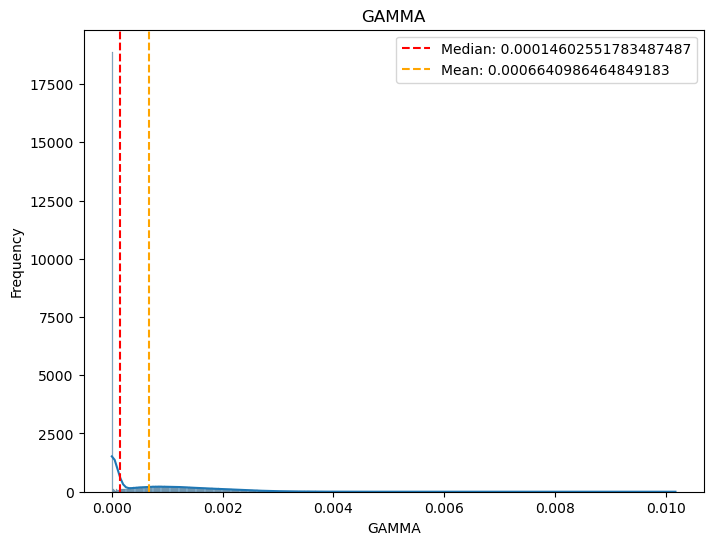

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


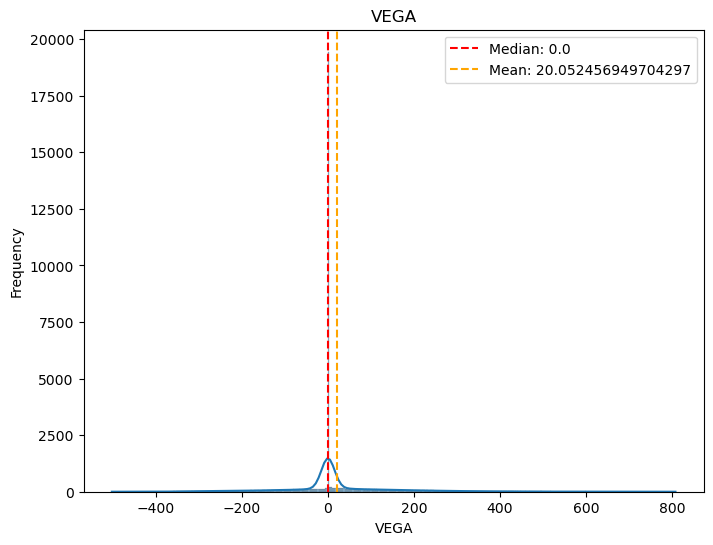

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'right-skewed'}


In [13]:
print(f"bull_result:\n")
static_summary(bull_result)


print(f"\n\n================================================================================================\n\n")


print(f"bear_result:\n")
static_summary(bear_result)


## bull spread 策略结果

bull_call_result:



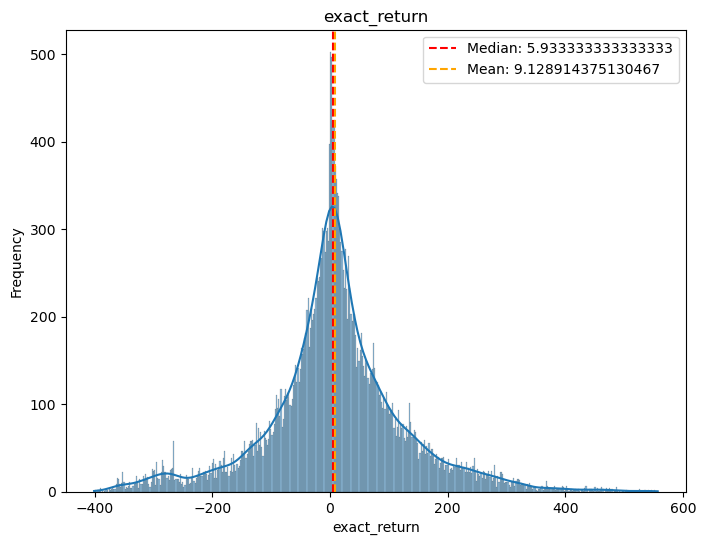

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


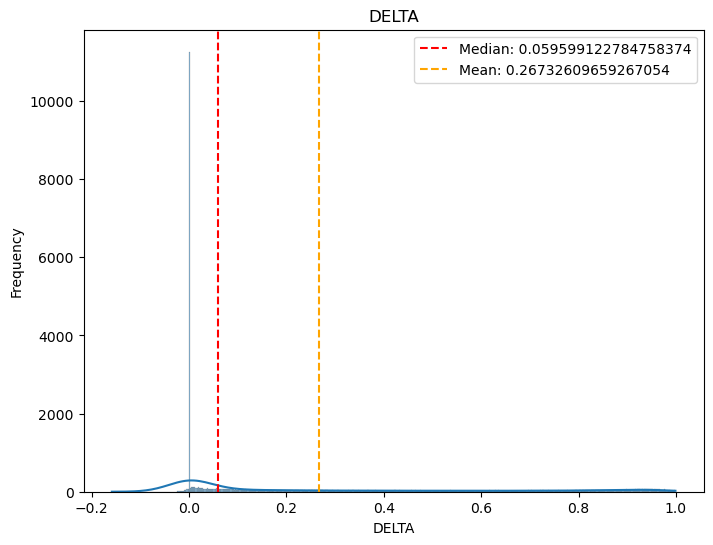

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


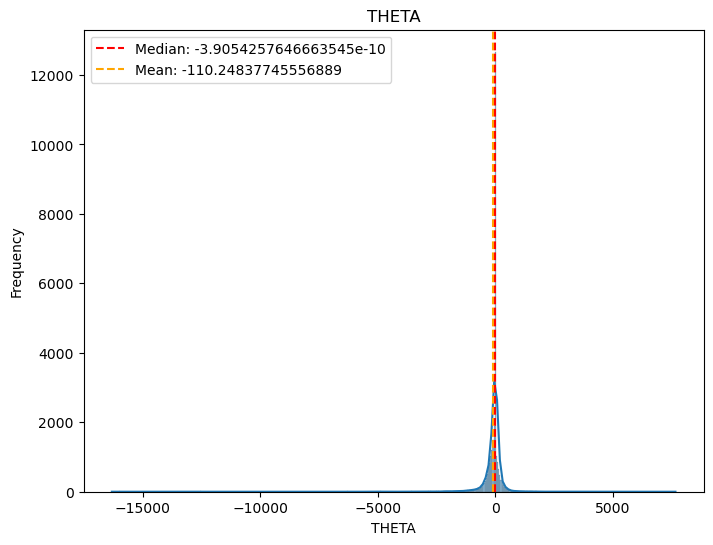

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'left-skewed'}


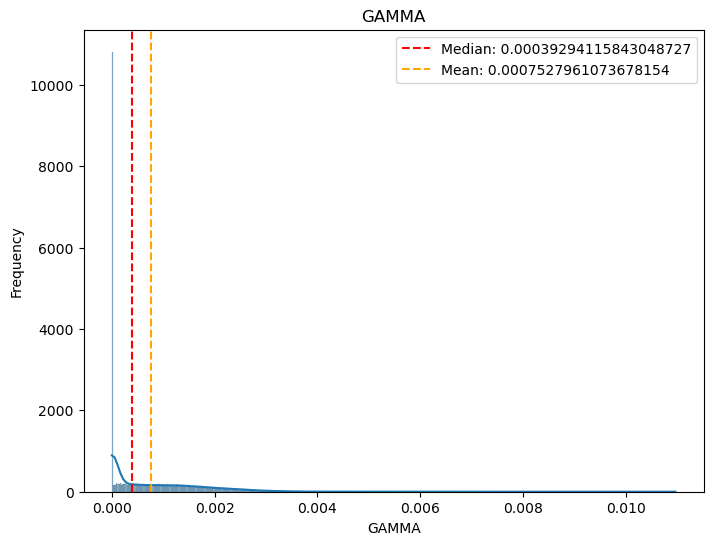

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


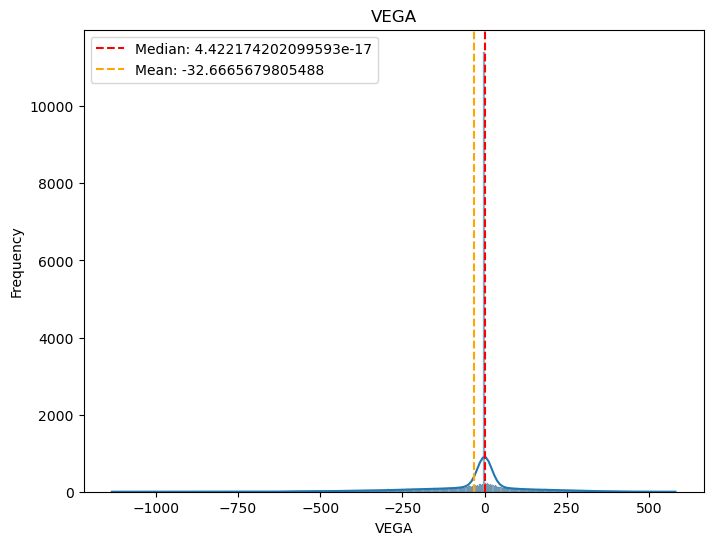

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'left-skewed'}




bull_put_result:



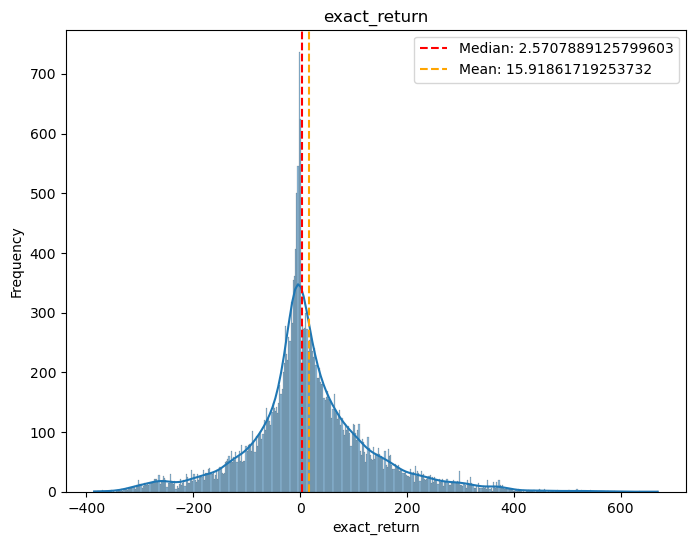

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


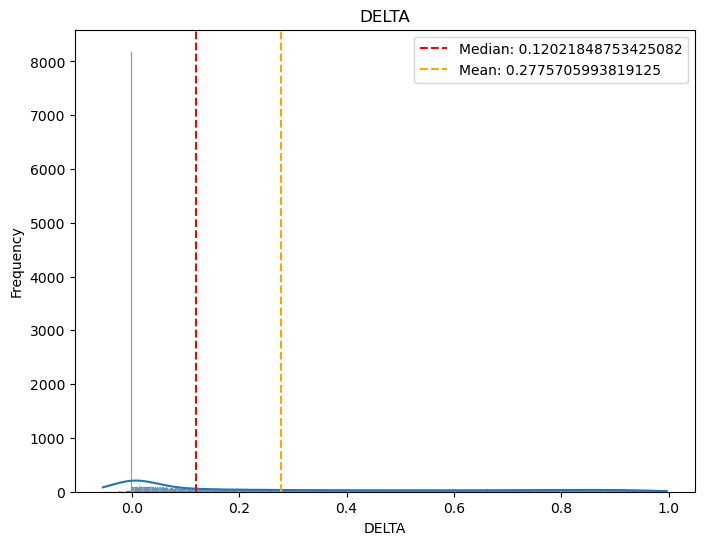

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


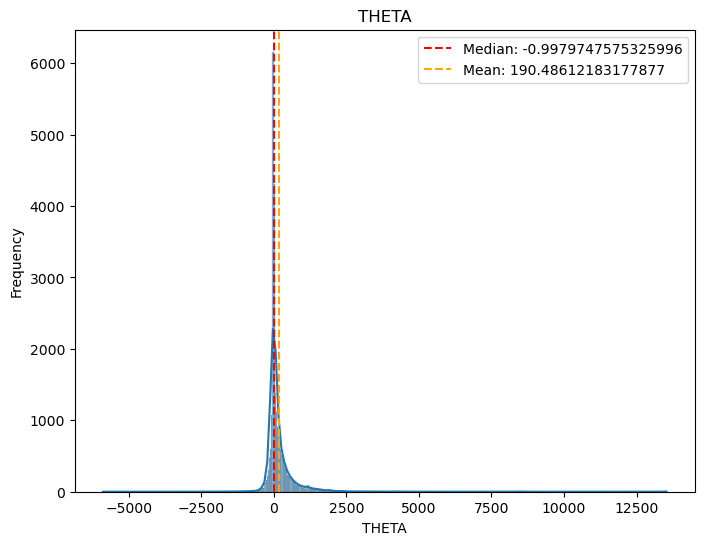

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'right-skewed'}


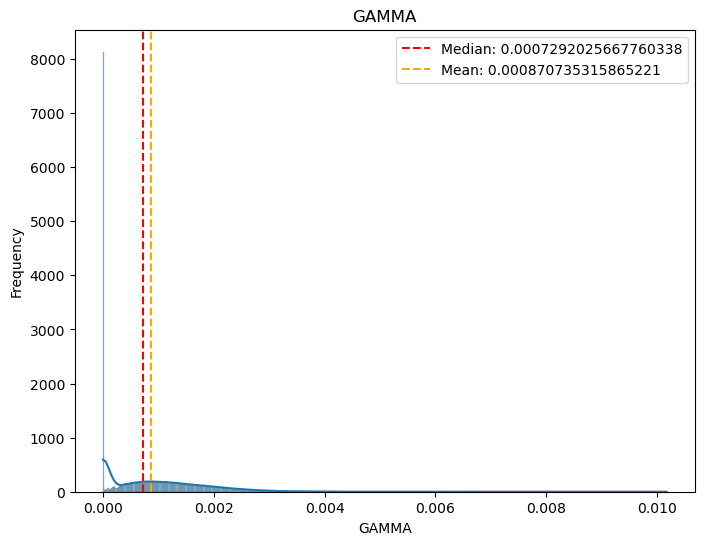

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


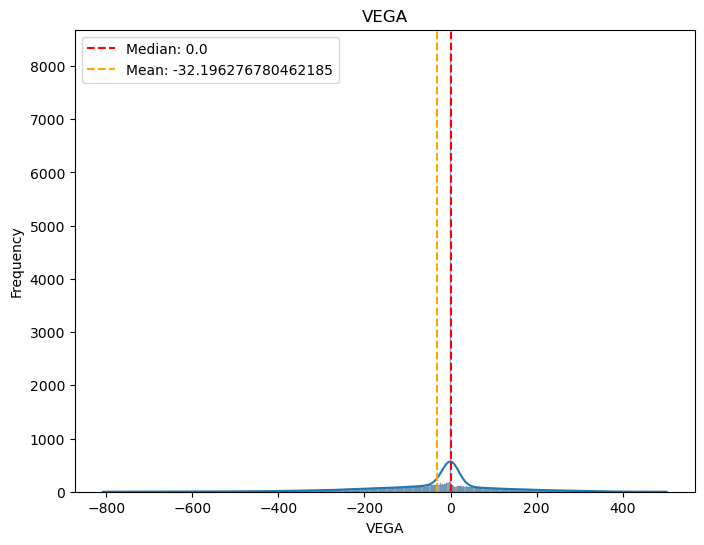

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'left-skewed'}


In [14]:
print(f"bull_call_result:\n")
static_summary(bull_call_groups)

print(f"\n\n================================================================================================\n\n")

print(f"bull_put_result:\n")
static_summary(bull_put_groups)


## bear spread 策略结果

bear_put_result:



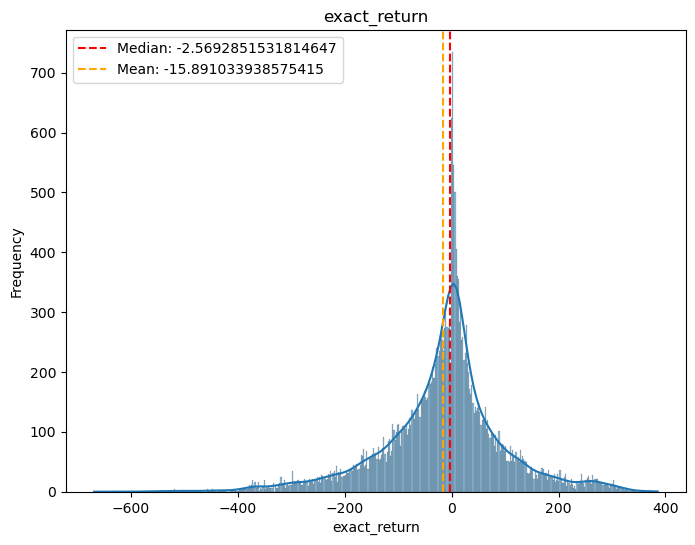

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'left-skewed'}


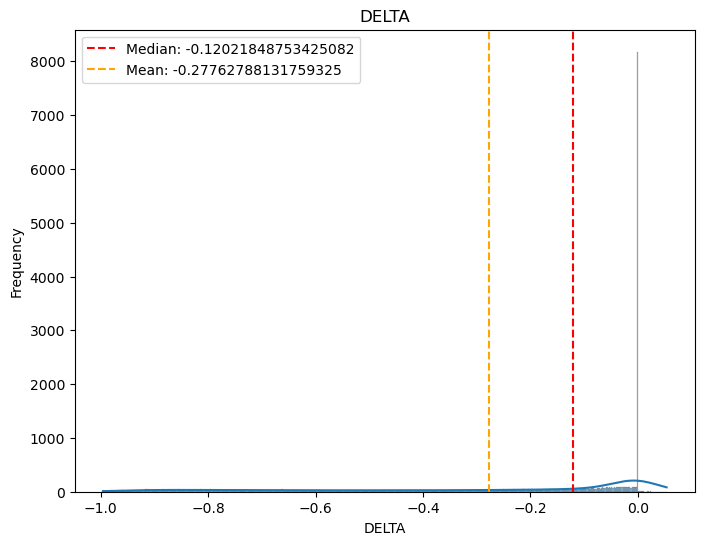

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'left-skewed'}


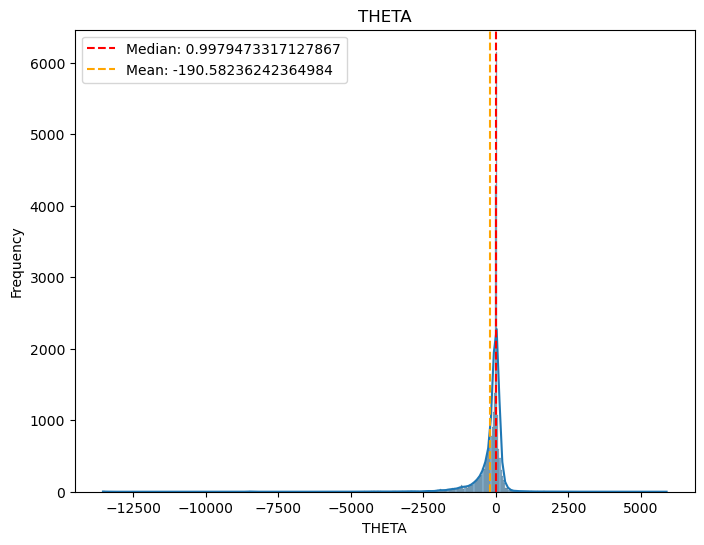

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'left-skewed'}


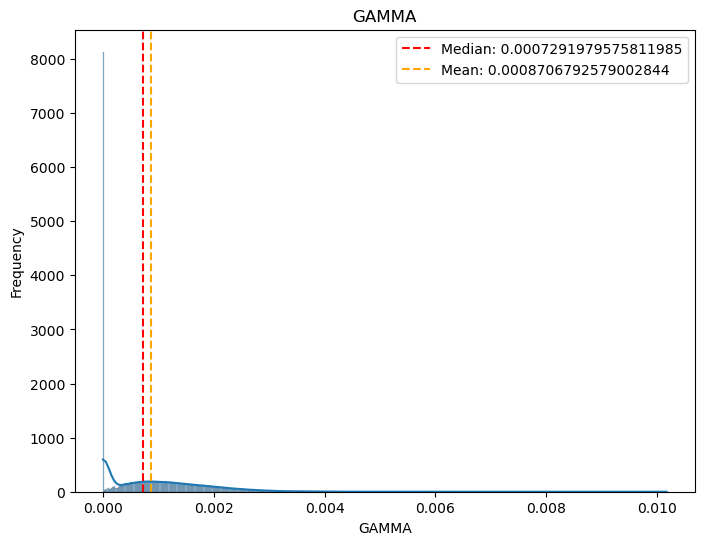

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}


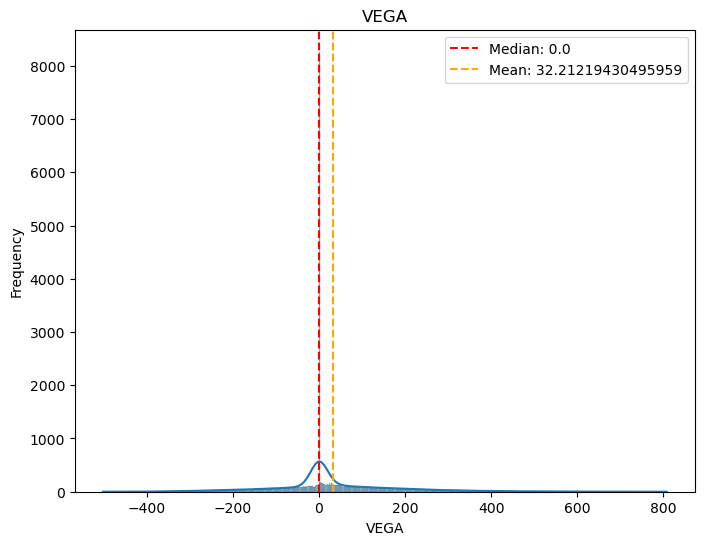

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'right-skewed'}




bear_call_result:



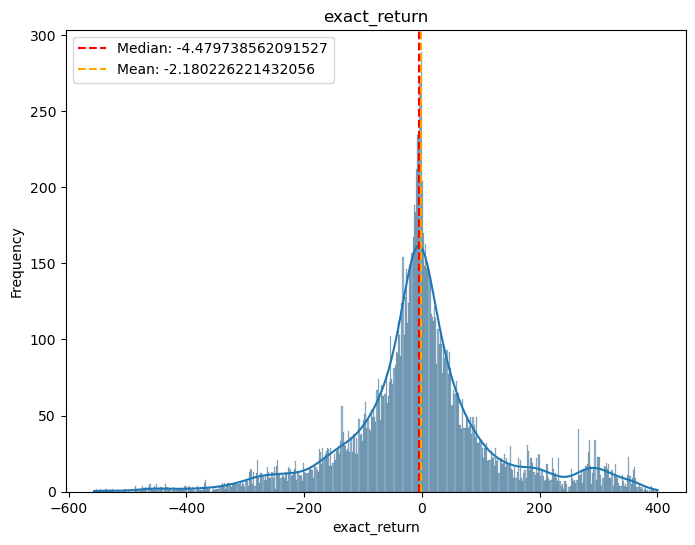

{'Tail Thickness': 'thin', 'Peak Shape': 'flat', 'Skew': 'left-skewed'}


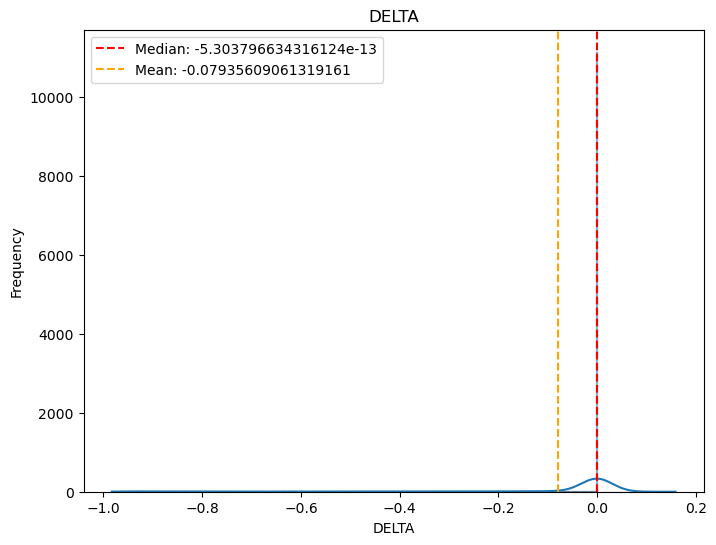

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'left-skewed'}


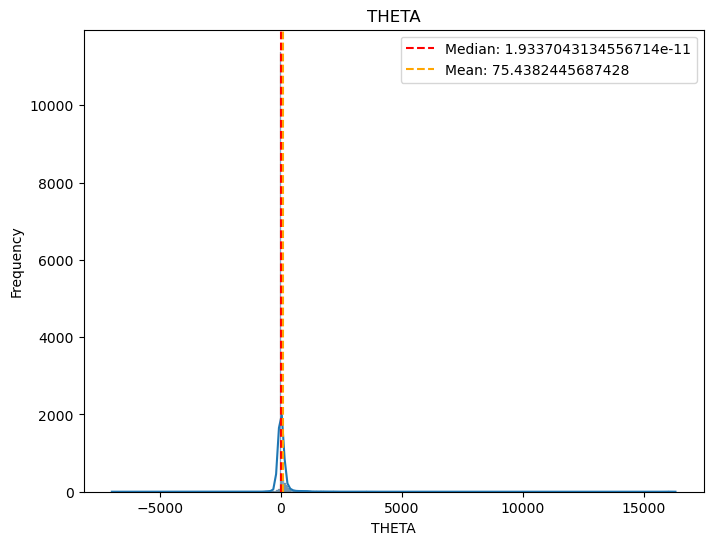

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'right-skewed'}


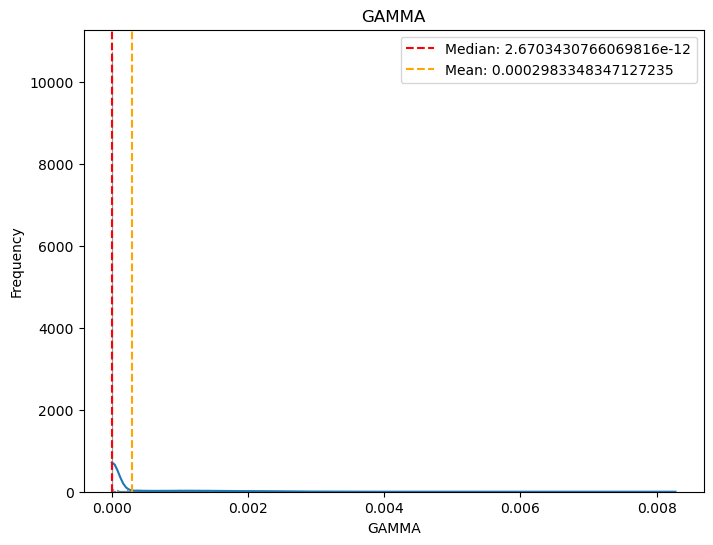

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'right-skewed'}


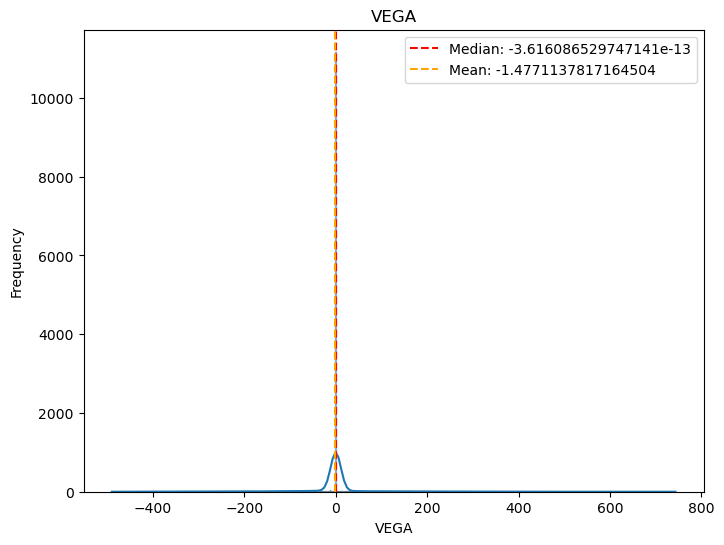

{'Tail Thickness': 'fat', 'Peak Shape': 'peaked', 'Skew': 'right-skewed'}


In [15]:
print(f"bear_put_result:\n")
static_summary(bear_put_groups)

print(f"\n\n================================================================================================\n\n")

print(f"bear_call_result:\n")
static_summary(bear_call_groups)

